In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import itertools
from sklearn.metrics import roc_auc_score
import pandas as pd
import pickle

In [2]:
EXP_ROOT = "/scratch/zeiberg.d/leveragingStructureFinalExperiments/experiments/"

In [6]:
REAL_DATASETS = ["income","employment","income_poverty_ratio","amazon_reviews","amazon_reviews_buffer"]

In [7]:
class Experiment:
    def __init__(self,pth):
        self.path = pth
        self.loadLabels()
        self.loadPreds()

    def loadLabels(self):
        try:
            self.yUnlabeledTest = np.load(os.path.join(self.path,
                                                      "yUnlabeledTest.npy"))
        except FileNotFoundError:
            self.yUnlabeledTest = None
            
    def loadLabels(self):
        try:
            self.yUnlabeledTest = np.load(os.path.join(self.path,
                                                      "yUnlabeledTest.npy"))
        except FileNotFoundError:
            self.yUnlabeledTest = None

    def getK(self):
        if not np.isnan(self.k):
            return self.k
        try:
            with open(os.path.join(self.path,"mm","clusterer.pkl"),"rb") as f:
                clusterer = pickle.load(f)
                self.clusterer = clusterer
            self.k = clusterer.n_clusters
        except FileNotFoundError:
            self.k = np.nan
        return self.k
        
    def loadPreds(self,skipsteps=[]):
        self.methodPreds = {}
        try:
            self.methodPreds["Group-Aware Global"] = np.load(os.path.join(self.path,
                                                                        "ag",
                                                                        "preds.npy"))
        except FileNotFoundError:
            return
        try:
            self.methodPreds["Cluster Global"] = np.load(os.path.join(self.path,
                                                                      "mm",
                                                                      "clusterGlobalPreds.npy"))

            self.methodPreds["Our Method"] = np.load(os.path.join(self.path,
                                                          "mm",
                                                          "preds.npy"))
        except FileNotFoundError:
            return
        
        try:
            self.methodPreds["Global Star"] = np.load(os.path.join(self.path,
                                                            "mmStar",
                                                            "clusterGlobalPreds.npy"))
            self.methodPreds["Star"] = np.load(os.path.join(self.path,
                                                            "mmStar",
                                                            "preds.npy"))
        except FileNotFoundError:
            return
        
        try:
            self.methodPreds["Global"] = np.load(os.path.join(self.path,
                                                              "mm2",
                                                              "clusterGlobalPreds.npy"))

            self.methodPreds["Label Shift"] = np.load(os.path.join(self.path,
                                                                   "mm2",
                                                                   "Preds.npy"))

        except FileNotFoundError:
            return
        try:
            self.methodPreds["coral"] = np.load(os.path.join(self.path,
                                                            "fe",
                                                            "preds.npy"))
        except FileNotFoundError:
            return
    def aucSeries(self):
        names, vals = list(zip(*[(m,roc_auc_score(self.yUnlabeledTest,preds)) for m,preds in self.methodPreds.items()]))
        return pd.Series(data=vals,index=names)

In [8]:
exp_sets = {}
for setting in range(1,3):
    for name in REAL_DATASETS:
        print(setting,name)
        exp_sets[(name,setting)] = [Experiment(pth) for pth in glob(f"/scratch/zeiberg.d/leveragingStructureFinalExperiments/experiments/{name}_setting_{setting}_*/")]

1 income
1 employment
1 income_poverty_ratio
1 amazon_reviews
1 amazon_reviews_buffer
2 income
2 employment
2 income_poverty_ratio
2 amazon_reviews
2 amazon_reviews_buffer


In [9]:
synth_exp_sets = {}
for setting in range(1,3):
    for dim in [1,4,16,64]:
        for nClusters in [1,2,4,8]:
            print(setting,dim,nClusters)
            synth_exp_sets[(setting,dim,nClusters)] = [Experiment(pth) for pth in \
                                                      glob(os.path.join(EXP_ROOT,f"synthetic_dim_{dim}_nClusters_{nClusters}_setting_{setting}_*/")) \
                                                      if "FAILED" not in pth]

1 1 1
1 1 2
1 1 4
1 1 8
1 4 1
1 4 2
1 4 4
1 4 8
1 16 1
1 16 2
1 16 4
1 16 8
1 64 1
1 64 2
1 64 4
1 64 8
2 1 1
2 1 2
2 1 4
2 1 8
2 4 1
2 4 2
2 4 4
2 4 8
2 16 1
2 16 2
2 16 4
2 16 8
2 64 1
2 64 2
2 64 4
2 64 8


In [10]:
tables = {}
for k,exps in exp_sets.items():
    print(k)
    series = []
    for e in exps:
        try:
            series.append(e.aucSeries())
        except ValueError:
            print(e.path)
    tables[k] = pd.DataFrame(series)

('income', 1)
('employment', 1)
('income_poverty_ratio', 1)
/scratch/zeiberg.d/leveragingStructureFinalExperiments/experiments/income_poverty_ratio_setting_1_3/
/scratch/zeiberg.d/leveragingStructureFinalExperiments/experiments/income_poverty_ratio_setting_1_2/
/scratch/zeiberg.d/leveragingStructureFinalExperiments/experiments/income_poverty_ratio_setting_1_4/
('amazon_reviews', 1)
('amazon_reviews_buffer', 1)
('income', 2)
('employment', 2)
('income_poverty_ratio', 2)
('amazon_reviews', 2)
('amazon_reviews_buffer', 2)


In [11]:
import pathlib

missing = []
for k,exps in exp_sets.items():
    rt = pathlib.Path(exps[0].path).name
    rt = rt[:rt.rfind("_")]
    exp_names = set([pathlib.Path(e.path).name for e in exps])
    for num in range(25):
        pth = rt+f"_{num}"
        if pth not in exp_names:
            missing.append(pth)

In [12]:
missing

[]

In [13]:
synth_tables = {}
synth_missing = []
for k,exps in synth_exp_sets.items():
    series = []
    for e in exps:
        try:
            series.append(e.aucSeries())
        except ValueError:
            p = pathlib.Path(e.path).name
            print("cannot process ",p)
            synth_missing.append(p)
            continue
    synth_tables[k] = pd.DataFrame(series)

In [14]:
len(synth_missing)

0

In [15]:
synth_missing

[]

In [16]:
missing_dict = {}
for setting in range(1,3):
    for dim in [1,4,16,64]:
        for nClusters in [1,2,4,8]:
            template = f"synthetic_dim_{dim}_nClusters_{nClusters}_setting_{setting}_"
            names = [e for e in synth_missing if template in e]
            if len(names):
                missing_dict[(dim,nClusters,setting)] = ",".join([n[n.rfind("_")+1:] for n in names])

### Real-Data Experiment Iteration Counts `with` CORAL

In [17]:
[(n,t.dropna().shape[0]) for n,t in tables.items()]

[(('income', 1), 25),
 (('employment', 1), 21),
 (('income_poverty_ratio', 1), 13),
 (('amazon_reviews', 1), 20),
 (('amazon_reviews_buffer', 1), 18),
 (('income', 2), 25),
 (('employment', 2), 23),
 (('income_poverty_ratio', 2), 25),
 (('amazon_reviews', 2), 18),
 (('amazon_reviews_buffer', 2), 13)]

In [18]:
name,vals = zip(*[(n,t.dropna().mean(axis=0).sort_values()) for n,t in tables.items()])
summaryTable = pd.DataFrame(vals,index=name)

In [19]:
summaryTable.style.highlight_max(subset=[c for c in summaryTable.columns if "Star" not in c],axis=1)

,,coral,Group-Aware Global,Label Shift,Star,Our Method,Global,Global Star,Cluster Global
income,1,0.865464,0.869568,0.872545,0.872592,0.873501,0.879024,0.879056,0.879184
employment,1,0.882663,0.897005,0.900090,0.900111,0.898363,0.902938,0.902932,0.903168
income_poverty_ratio,1,0.792472,0.811559,0.812209,0.812367,0.812458,0.824916,0.825061,0.828086
amazon_reviews,1,0.743677,0.744900,0.695404,0.695505,0.706293,0.744842,0.744814,0.759404
amazon_reviews_buffer,1,0.744092,0.745371,0.698064,0.698340,0.707014,0.745163,0.745125,0.759141
income,2,0.852626,0.846440,0.875993,0.899863,0.884228,0.869522,0.870757,0.871484
employment,2,0.850948,0.865473,0.903709,0.926750,0.916250,0.896973,0.898198,0.897962
income_poverty_ratio,2,0.760210,0.768209,0.831217,0.861756,0.849960,0.815569,0.820174,0.819832
amazon_reviews,2,0.708596,0.674388,0.701567,0.790703,0.751413,0.718166,0.754906,0.744852
amazon_reviews_buffer,2,0.705344,0.665975,0.692058,0.774184,0.736227,0.717559,0.751575,0.741008


In [17]:
table1 = summaryTable.loc(axis=0)[:,1].T.loc[["coral","Global", "Group-Aware Global", "Cluster Global", "Label Shift", "Our Method","Star"]]
table1.columns = table1.columns.droplevel(1)
amazon1 = table1["amazon_reviews"]
table1 = table1.drop("amazon_reviews",axis=1)

In [18]:
amazon1

coral                 0.743677
Global                0.744842
Group-Aware Global    0.744900
Cluster Global        0.759404
Label Shift           0.695404
Our Method            0.706293
Star                  0.695505
Name: amazon_reviews, dtype: float64

In [19]:
table1

,income,employment,income_poverty_ratio
coral,0.865464,0.882663,0.792472
Global,0.879024,0.902938,0.824916
Group-Aware Global,0.869568,0.897005,0.811559
Cluster Global,0.879184,0.903168,0.828086
Label Shift,0.872545,0.900090,0.812209
Our Method,0.873501,0.898363,0.812458
Star,0.872592,0.900111,0.812367


In [20]:
amazon1.to_latex("figures/amazon_1.latex",
               header=["Amazon"],
               float_format="%.3f",
               index_names=["CORAL","Global","Group-Aware Global","Cluster Global", "Label Shift", "Our Method","True Clustering"],
               caption="Average AUC calculated on the held-out test set for Amazon datasets in setting 1.",
                     label="tab:amazonSetting1",)

/tmp/ipykernel_17459/3418435884.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  amazon1.to_latex("figures/amazon_1.latex",


In [84]:
table1.to_latex("figures/table_1.latex",
               header=["Income","Employment","IPR"],
               float_format="%.3f",
               index_names=["CORAL","Global","Group-Aware Global","Cluster Global", "Label Shift", "Our Method","True Clustering"],
               caption="Average AUC calculated on the held-out test set for real-world datasets in setting 1.",
                     label="tab:realSetting1",)

/tmp/ipykernel_7491/3329360191.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table1.to_latex("figures/table_1.latex",


In [21]:
table2 = summaryTable.loc(axis=0)[:,2].T.loc[["coral","Global", "Group-Aware Global", "Cluster Global", "Label Shift", "Our Method","Star"]]
table2.columns = table2.columns.droplevel(1)
amazon2 = table2["amazon_reviews"]
table2 = table2.drop("amazon_reviews",axis=1)

In [22]:
amazon2

coral                 0.708596
Global                0.718166
Group-Aware Global    0.674388
Cluster Global        0.744852
Label Shift           0.701567
Our Method            0.751413
Star                  0.790703
Name: amazon_reviews, dtype: float64

In [86]:
table2

,income,employment,income_poverty_ratio
coral,0.852626,0.850948,0.760210
Global,0.869522,0.896973,0.815569
Group-Aware Global,0.846440,0.865473,0.768209
Cluster Global,0.871484,0.897962,0.819832
Label Shift,0.875993,0.903709,0.831217
Our Method,0.884228,0.916250,0.849960
Star,0.899863,0.926750,0.861756


In [23]:
amazon2.to_latex("figures/amazon_2.latex",
               header=["Amazon"],
               float_format="%.3f",
               index_names=["CORAL","Global","Group-Aware Global","Cluster Global", "Label Shift", "Our Method","True Clustering"],
               caption="Average AUC calculated on the held-out test set for Amazon datasets in setting 2.",
                     label="tab:amazonSetting2",)

/tmp/ipykernel_17459/1965133370.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  amazon2.to_latex("figures/amazon_2.latex",


In [24]:
amazonTable = pd.DataFrame({"Setting 1":amazon1,
                            "Setting 2":amazon2})

In [25]:
amazonTable

,Setting 1,Setting 2
coral,0.743677,0.708596
Global,0.744842,0.718166
Group-Aware Global,0.744900,0.674388
Cluster Global,0.759404,0.744852
Label Shift,0.695404,0.701567
Our Method,0.706293,0.751413
Star,0.695505,0.790703


In [26]:
amazonTable.to_latex("figures/amazonTable.latex",
               float_format="%.3f",
               index_names=["CORAL","Global","Group-Aware Global","Cluster Global", "Label Shift", "Our Method","True Clustering"],
               caption="Average AUC calculated on the held-out test set for Amazon datasets in settings 1 and 2.",
                     label="tab:amazon",)

/tmp/ipykernel_17459/2634083970.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  amazonTable.to_latex("figures/amazonTable.latex",


In [87]:
table2.to_latex("figures/table_2.latex",
               header=["Income","Employment","IPR"],
               float_format="%.3f",
               index_names=["CORAL","Global","Group-Aware Global","Cluster Global", "Label Shift", "Our Method","True Clustering"],
               caption="Average AUC calculated on the held-out test set for real-world datasets in setting 2.",
                     label="tab:realSetting2",)

/tmp/ipykernel_7491/2051925905.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table2.to_latex("figures/table_2.latex",


In [23]:
name,vals = zip(*[(n,t.dropna().mean(axis=0).sort_values()) for n,t in synth_tables.items()])
synth_summaryTable = pd.DataFrame(vals,index=name)

In [24]:
synth_summaryTable.style.highlight_max(subset=[c for c in synth_summaryTable.columns if "Star" not in c],axis=1)

In [25]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 34})
def plotRelPerf(tbl,savepath=None,ax=None,ticks=True,axLBL=True,title=None,
               cols=lambda tbl:tbl.columns,
               ticklabels = None,
               rel_to="Global",
                ytick_locs=np.arange(-20,25,5)):
    g = tbl[rel_to]
    cols = cols(tbl)
    rel = tbl.loc[:,cols].apply(lambda col: (col-g)/g) * 100
    if ax is None:
        ax = plt.subplot()
    ax.boxplot(rel)
    ax.violinplot(rel)
    if ticks:
        if ticklabels is None:
            ticklabels = cols
        labels = ax.set_xticks(np.arange(1,len(ticklabels)+1),
                        ticklabels,
                        rotation=45,ha="right")
    else:
        ax.tick_params(axis='x',          # changes apply to the x-axis
                           which='both',      # both major and minor ticks are affected
                           bottom=False,      # ticks along the bottom edge are off
                           top=False,         # ticks along the top edge are off
                           labelbottom=False) # labels along the bottom edge are off
    if axLBL:
        ax.set_ylabel("Relative AUC (%)")
        ax.set_yticks(ytick_locs,
                 [str(i) for i in ytick_locs])
    if title is not None:
        ax.set_title(title)
    if savepath is not None:
        plt.savefig(savepath,format="pdf")
    return ax

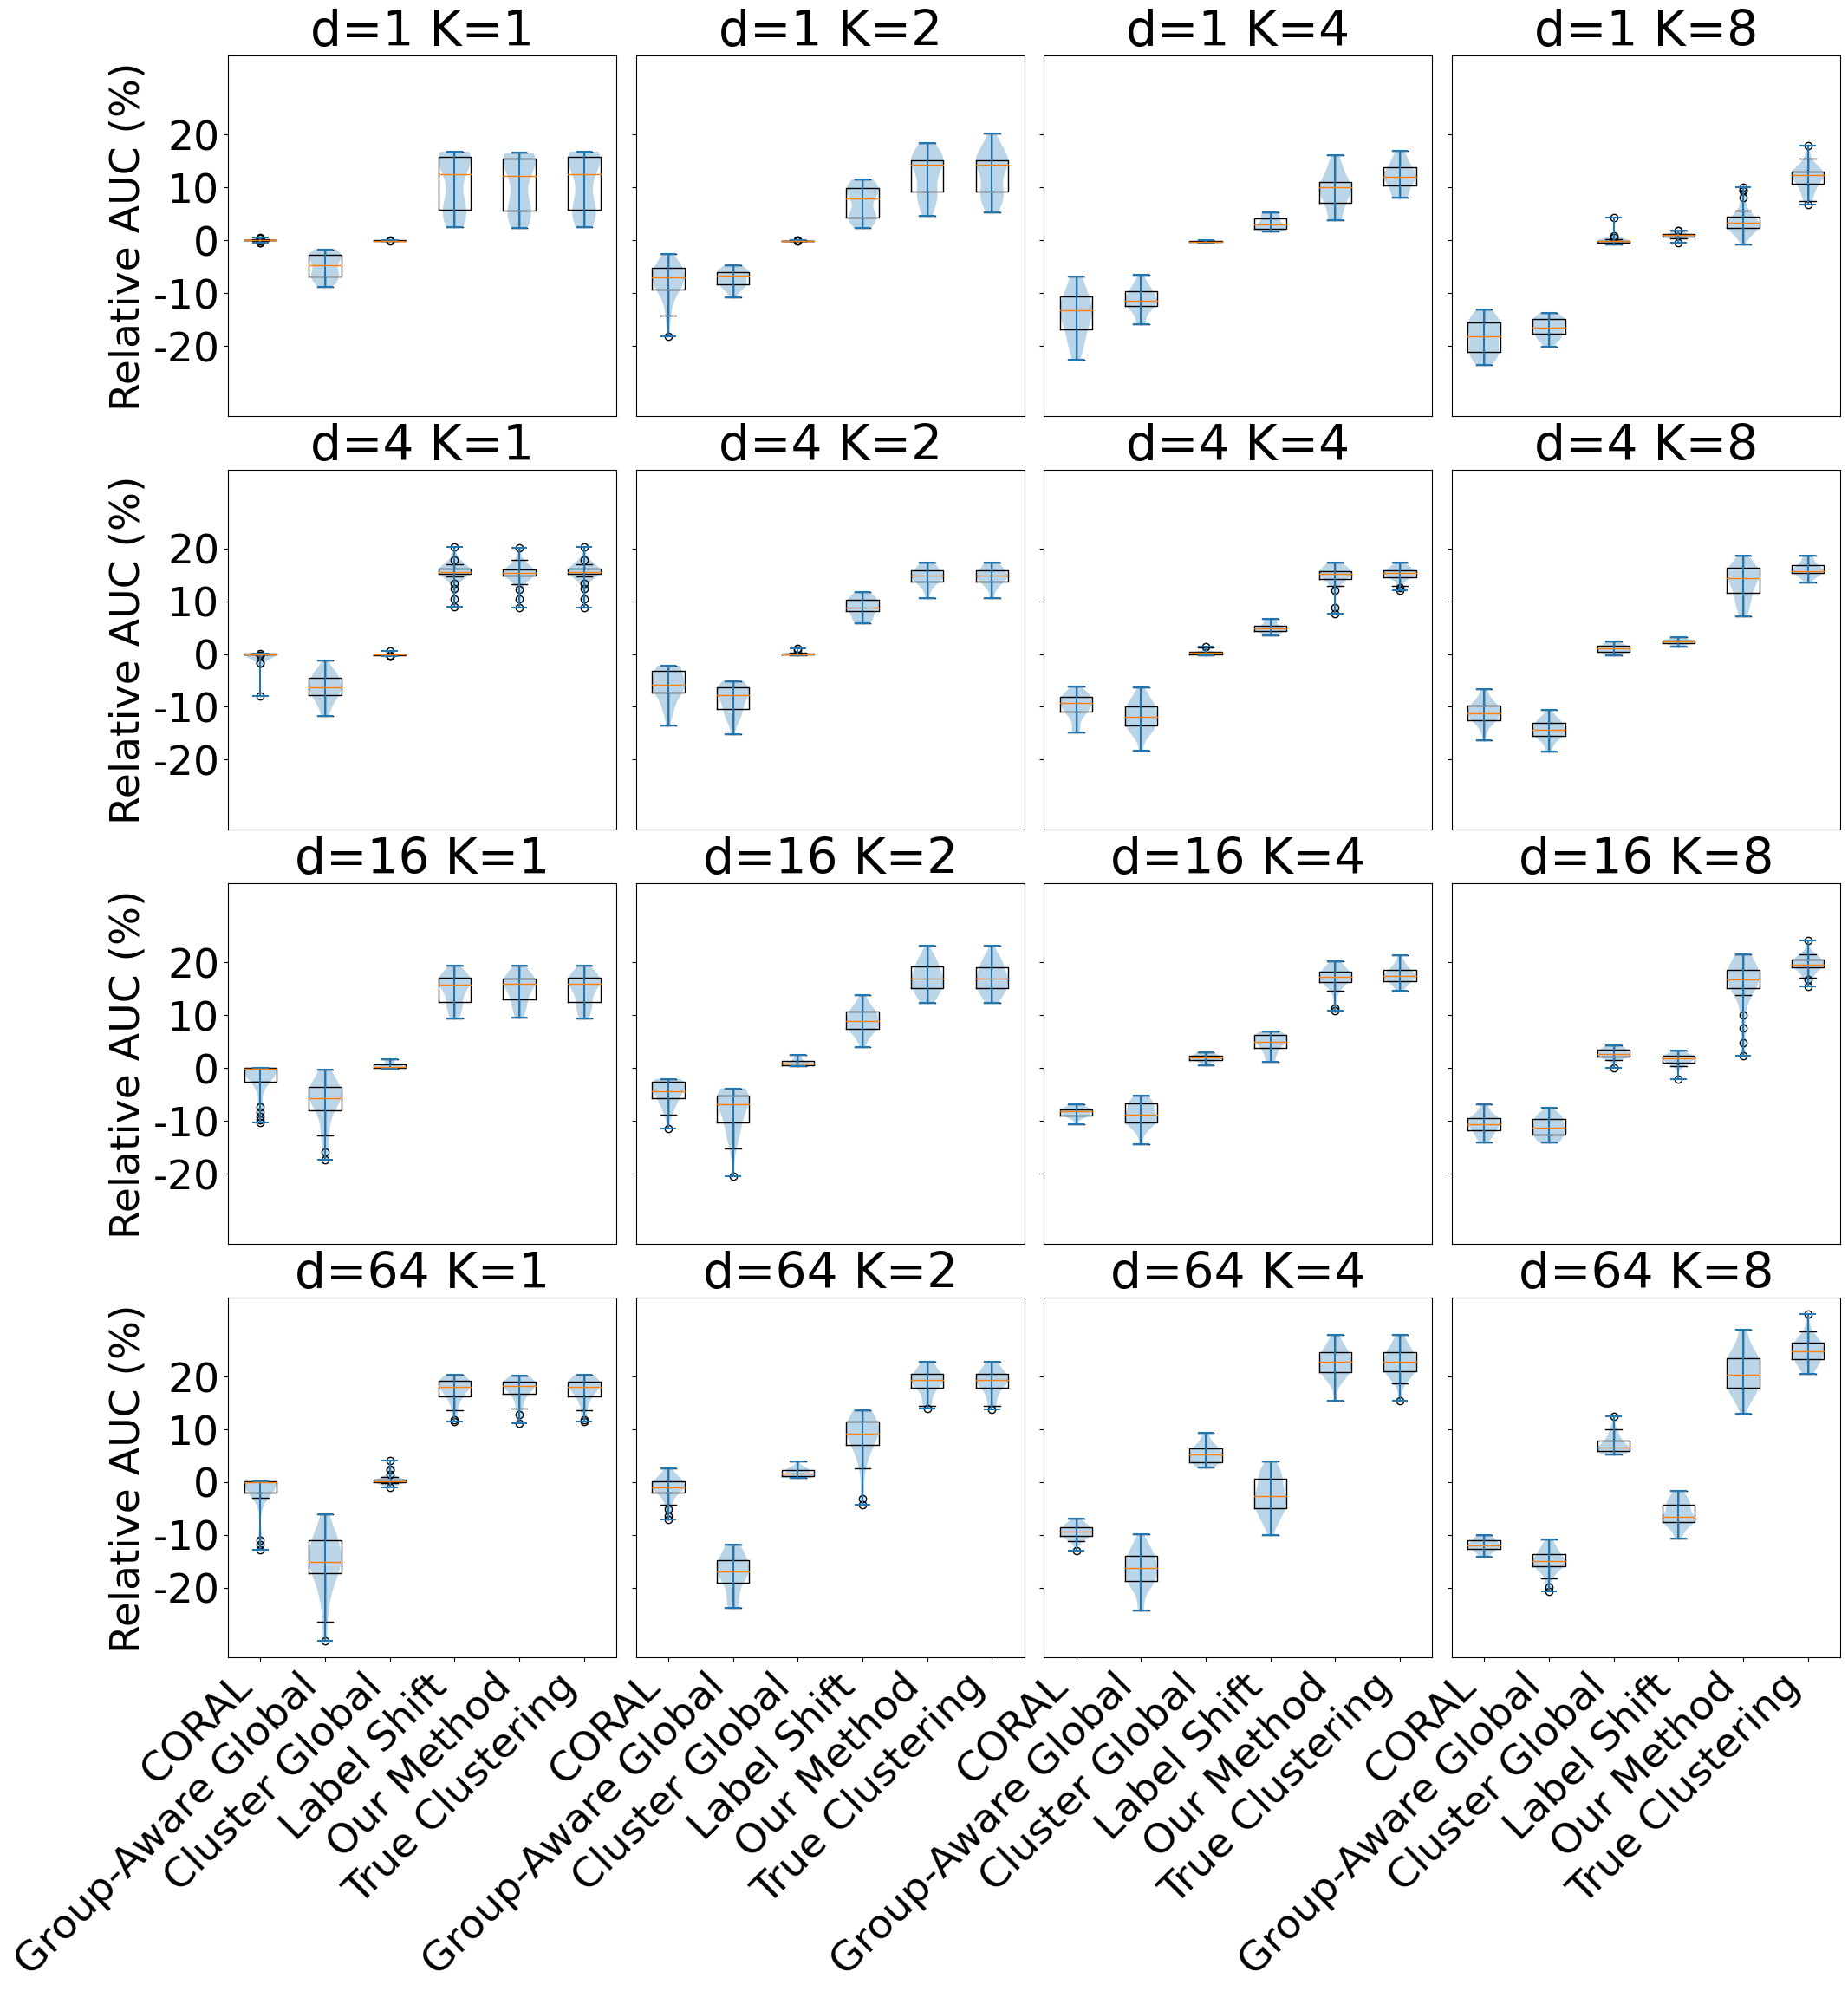

In [27]:
synthDFig2,synthDax2 = plt.subplots(4,4,figsize=(24,24),sharey=True,)
for i,d in enumerate([1,4,16,64]):
    for j,k in enumerate([1,2,4,8]):
        plotRelPerf(synth_tables[(2,d,k)].dropna(),
                    ax=synthDax2[i,j],
                   ticks=i==3,
                   axLBL=j==0,
                   title=f"d={d} K={k}",
                   cols=lambda tbl:["coral","Group-Aware Global",
                                    "Cluster Global",
                                    "Label Shift","Our Method","Star"],
                   ticklabels=["CORAL","Group-Aware Global",
                                    "Cluster Global",
                                    "Label Shift","Our Method","True Clustering"],
                   rel_to="Global",ytick_locs=np.arange(-20,30,10))
synthDFig2.subplots_adjust(hspace = .15,wspace=.05)

In [28]:
synthDFig2.savefig("figures/synthetic_breakdown.pdf",format="pdf", bbox_inches='tight')

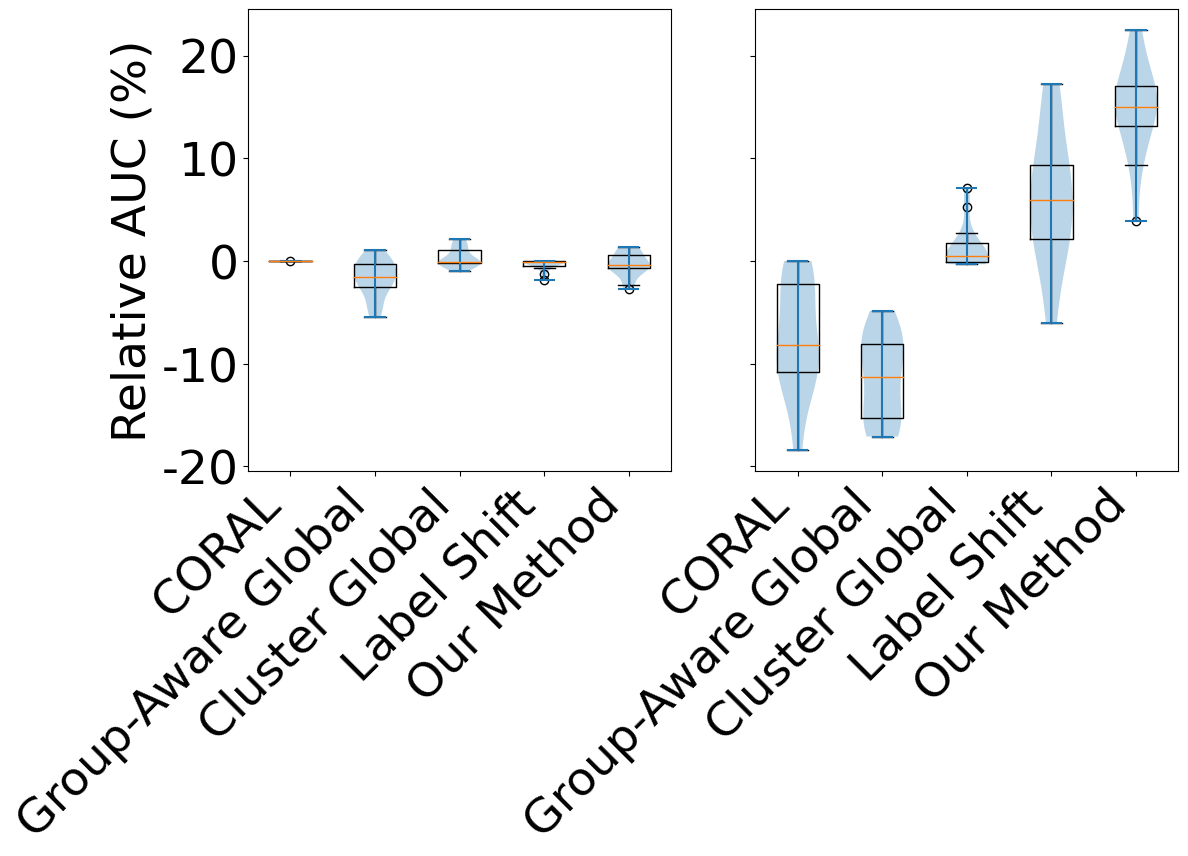

In [88]:
synthfig,synthax= plt.subplots(1,2,figsize=(12,6),sharey=True)

synth1 = plotRelPerf(synth_summaryTable.loc[1],ax=synthax[0],
                     cols=lambda tbl:["coral","Group-Aware Global",
                                      "Cluster Global",
                                      "Label Shift","Our Method"],
                     ytick_locs=np.arange(-20,30,10),
                    ticklabels=["CORAL","Group-Aware Global",
                                    "Cluster Global",
                                    "Label Shift","Our Method"],)

synth2 = plotRelPerf(synth_summaryTable.loc[2],ax=synthax[1],axLBL=False,
                    cols=lambda tbl:["coral","Group-Aware Global",
                                      "Cluster Global",
                                      "Label Shift","Our Method"],
                    ticklabels=["CORAL","Group-Aware Global",
                                    "Cluster Global",
                                    "Label Shift","Our Method"],)

In [90]:
synthfig.savefig("figures/synthetic.pdf",format="pdf",bbox_inches='tight')